In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import gray2rgb
import cv2
from pandas import read_csv
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from fd import get_file_list
from plotting import plot_face_bb

Using gpu device 0: GeForce GTX 960


In [4]:
train_folder = '/home/arya_03/data/faceScrub/train/'

In [54]:
fnames, bboxes = get_file_list(train_folder)

In [55]:
fnames[0], bboxes[0]

('/home/arya_03/data/faceScrub/train/Charlie_Day/ceb30b3be359b8e424b52421b7f6e40ca7af94d8d3de42037d687cfdc6ed8d51.jpg',
 [0.252, 0.26800001, 0.736, 0.75300002])

In [60]:
np.array(list(bboxes)).shape

(83039, 4)

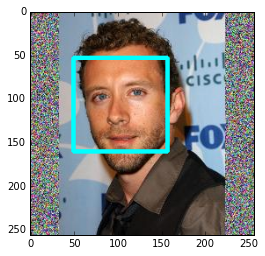

In [8]:
plot_face_bb(fnames[1000], bboxes[1000])

In [15]:
im = imread(fnames[0])

In [19]:
X = []
X.append(np.transpose(im, [2,0,1]))
X.append(None)
X.append(np.transpose(im, [2,0,1]))
X.append(None)

In [20]:
np.array(X).shape

(4,)

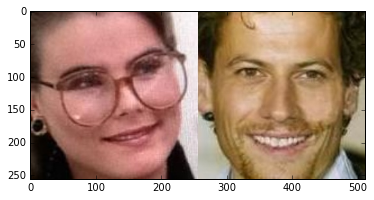

In [14]:
plt.imshow(imread('/home/arya_03/data/concat/data/0/bb008b9e367f001837b3adabb2b46323.jpg'))